# Classifying the MNIST Dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random as rd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
SIZE = 28
LABELS = 10
CHANNELS = 1
BREAKS = 100

---
## Visualizer Functions
These are some helper functions

In [3]:
def digits(data, labels):
    fig, ax = plt.subplots(3, 10, figsize = (20, 8))
    for i in xrange(3):
        for j in xrange(10):
            x = rd.randint(0, len(data))
            ax[i,j].matshow(data.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
            ax[i,j].set_title("Label: {}".format(labels[x]))
            ax[i,j].axis('off')
    plt.show()

In [4]:
def plotter(history):
    at, av, lt, lv = zip(*history)
    fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

    ax1.plot(np.arange(0, len(at), 1), at,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(at[-1]))
    ax1.plot(np.arange(0, len(av), 1), av,".-", color='#FFA933', label="Validation: {0:.2f}%".format(av[-1]))
    ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

    ax2.plot(np.arange(0, len(lt), 1), lt,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lt[-1]))
    ax2.plot(np.arange(0, len(lv), 1), lv,".-", color='#FFA933', label="Validation: {0:.2f}".format(lv[-1]))
    ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
    plt.show()

---
## Data Import

In [5]:
data = pd.read_csv('/Users/desiredewaele/Google Drive/Datasets/MNIST Data/train.csv')
test = pd.read_csv('/Users/desiredewaele/Google Drive/Datasets/MNIST Data/test.csv')
labels = data.pop('label')

In [6]:
data.tail()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
labels.tail()

41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, dtype: int64

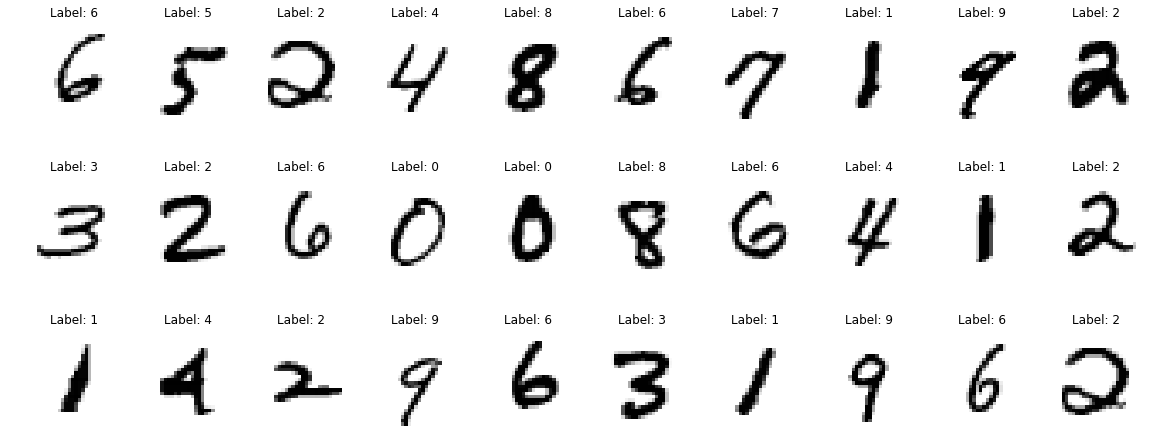

In [8]:
digits(data.values, labels)

---
## Data Preproccessing
Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [9]:
print('Training set', data.shape, labels.shape)
print('Testing set', test.shape)

('Training set', (42000, 784), (42000,))
('Testing set', (28000, 784))


In [10]:
data = data.values.reshape(-1, SIZE, SIZE, CHANNELS)
test = test.values.reshape(-1, SIZE, SIZE, CHANNELS)
labels = pd.get_dummies(labels).values

In [11]:
print('Training set', data.shape, labels.shape)
print('Testing set', test.shape)

('Training set', (42000, 28, 28, 1), (42000, 10))
('Testing set', (28000, 28, 28, 1))


In [12]:
from sklearn.model_selection import train_test_split
trainX, validX, trainY, validY = train_test_split(data, labels, train_size=32000, random_state=100)

In [13]:
print('Training set:', trainX.shape, trainY.shape)
print('Validation set:', validX.shape, validY.shape)
print('Testing set:', test.shape)

('Training set:', (32000, 28, 28, 1), (32000, 10))
('Validation set:', (10000, 28, 28, 1), (10000, 10))
('Testing set:', (28000, 28, 28, 1))


---
## Convolutional Neural Network

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [14]:
BATCH = 128
PATCH = 5
DEPTH = 8
HIDDEN = 1024
RATE = 0.0005
STEPS = 20000

In [15]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE, CHANNELS))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, 2*DEPTH], stddev=0.1))
    w3 = tf.Variable(tf.truncated_normal([SIZE // 4 * SIZE // 4 * 2*DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

    # Model.
    def model(x):
        # Convolutional layer 1
        x = tf.nn.conv2d(x, w1, [1, 1, 1, 1], padding='SAME') + b1
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Convolutional layer 2
        x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME') + b2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Fully connected layer
        x = tf.reshape(x, (-1, SIZE // 4 * SIZE // 4 * 2*DEPTH))
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.RMSPropOptimizer(RATE).minimize(loss)

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(logits, axis=1),"probabilities": tf.nn.softmax(logits)}
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions["classes"], tf.argmax(tfDataY, axis=1)))) * 100

In [16]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :, :, :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: batchX, tfDataY: batchY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: batchX, tfDataY: batchY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
            print ".",
    predictions = session.run(predictions, {tfDataX: test})
    #accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    #print('\nTest accuracy: %.2f%%' % accuracy)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


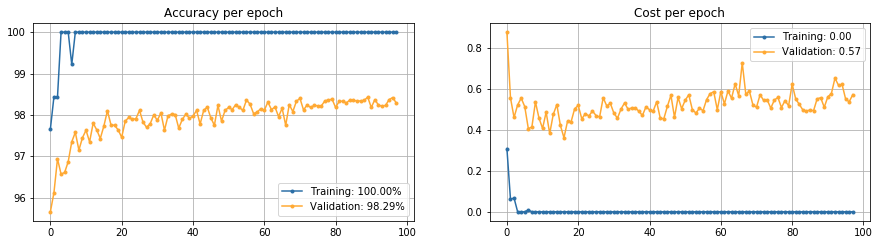

In [22]:
plotter(history[2:])

## Predictions on Test Set

In [18]:
print(predictions["classes"][0:3])
print(predictions["probabilities"][0:3])

[2 0 9]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


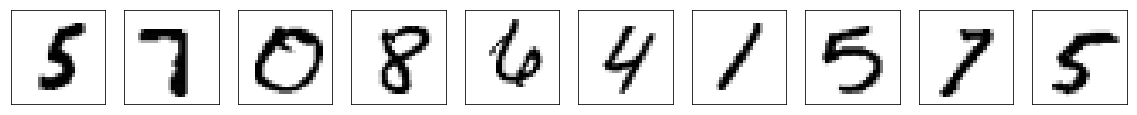

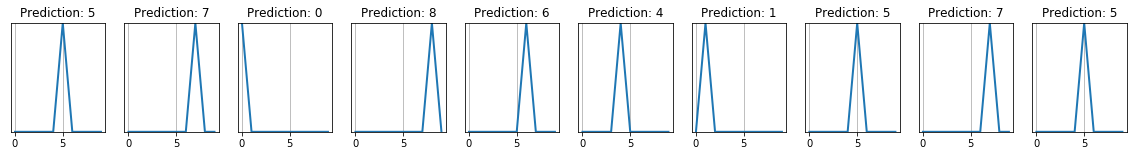

In [25]:
fig1, ax1 = plt.subplots(1, 10, figsize = (20, 2))
fig2, ax2 = plt.subplots(1, 10, figsize = (20, 2))

for t in xrange(10):
    x = rd.randint(0, len(test))
    ax1[t].matshow(test.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
    ax1[t].get_yaxis().set_visible(False); ax1[t].get_xaxis().set_visible(False)
    ax2[t].plot(predictions["probabilities"][x], lw=2)
    ax2[t].set_title("Prediction: {}".format(predictions["classes"][x]))
    ax2[t].get_yaxis().set_visible(False); ax2[t].set_ylim([0, 1]); ax2[t].grid(True)
plt.show()

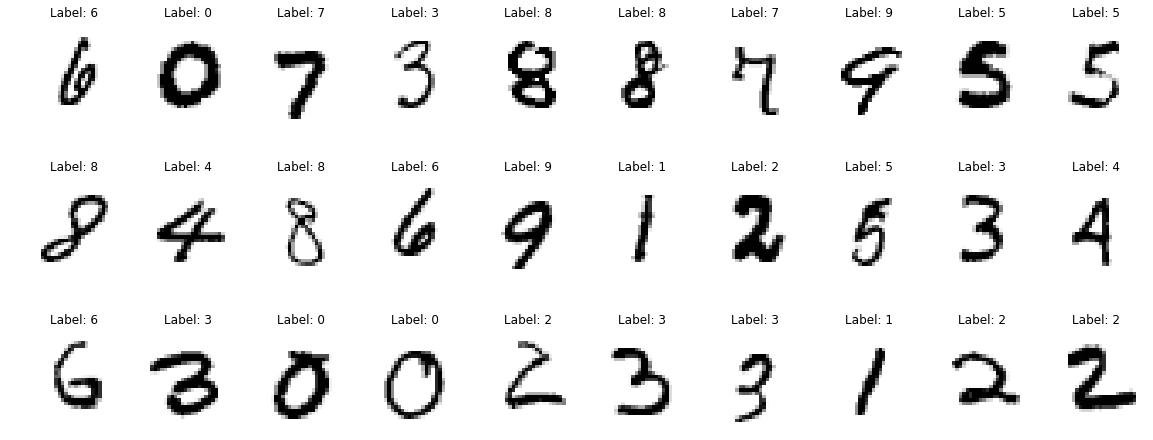

In [20]:
digits(test, predictions["classes"])

In [21]:
submission = pd.DataFrame({'ImageId': range(1, len(predictions["classes"])+1), 'Label':predictions["classes"]})
submission.to_csv('submission.csv', index=False)
submission.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2
